In [1]:
import numpy as np
import torch
import einops
import os
import pandas as pd
from coref import COREF_ROOT
from coref.utils import cache
from functools import partial

from coref.datasets.common import Name, Attr, Statement

from coref.datasets.api import load_vocab, generate_prompts, generate_tokenized_prompts
from coref.models import fetch_model

import matplotlib.pyplot as plt
import seaborn as sns
import transformer_lens.utils as utils

import coref.representations as rep


import coref.data_collection as dc

importing dataset common


Found cached dataset json (/scratch/users/fjiahai/huggingface-cache/json/default-59895a63557c4e20/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:

def reduce_logit_mean(all_logits):
    '''
    all_logits: [..., name, batch, answer]
    '''
    return all_logits.mean(dim=-2)

def reduce_acc(all_logits, intended_answers):
    '''
    all_logits: [..., name, batch, answer]
    intended_answers: [..., name]
    '''
    
    intended_answers = torch.tensor(intended_answers)
    return (all_logits.argmax(dim=-1) == intended_answers[..., None]).float().mean(dim=-1)
    
def reduce_mean_correct_logit(all_logits, intended_answers, ignore_null=False):
    # intended_answers: [..., name]
    if ignore_null:
        all_logits = all_logits[..., :-1, :, :]
    mat = reduce_logit_mean(all_logits) # [..., name, answer]
    intended_answers = torch.tensor(intended_answers)[..., None]
    return torch.gather(mat, dim=-1, index=intended_answers)[..., 0]

def reduce_balanced_acc(all_logits, intended_answers, offsets=None, ignore_null=False):
    if ignore_null:
        all_logits = all_logits[..., :-1, :, :]
    if offsets is None:
        # median is taken over name and batch
        median = torch.flatten(all_logits, start_dim=-3, end_dim=-2).quantile(dim=-2, q=0.5) # we've lost both dimensions
        offsets = median[..., None, None, :] # restore dimensions
    rebalanced_logits = all_logits - offsets
    return reduce_acc(rebalanced_logits, intended_answers)

def reduce_distractor_acc(tensor, intended_answers):
    '''
    tensor: [..., name, batch, attr]
    '''
    baseline = tensor[..., -1:, :, :].quantile(dim=-2, q=0.5, keepdim=True)
    mat = tensor[..., :-1, :, :]
    return reduce_balanced_acc(mat, intended_answers=intended_answers, offsets=baseline)



def heatmap(ax, tensor):
    sns.heatmap(
        utils.to_numpy(tensor), ax=ax, annot=True, fmt=".2f", square=True, vmin=-5, vmax=0, cbar=False, cmap=sns.color_palette("dark:#5A9", as_cmap=True))

from matplotlib.patches import Rectangle
def plot_factorization(results, highlight=None):
    tens = reduce_logit_mean(results)
    num_row, num_col = 2, 2
    fig, axs = plt.subplots(num_row, num_col, figsize=(4.5, 4.5))
    plot_titles = {
        (0, 0): "None",
        (0, 1): "Attribute",
        (1, 0): "Entity",
        (1, 1): "Both"
    }
    coords = [(r, c) for r in range(num_row) for c in range(num_col)]
    highlight_squares = {
        (r, c): highlight[i] if highlight is not None else []
        for i, (r,c) in enumerate(coords)
    }
    for r in range(num_row):
        for c in range(num_col):
            ax = axs[r, c]
            heatmap(ax, tens[r, c, :, :])
            if (r, c) == (0, 0):
                ax.set_title('None')
            if (r, c) == (0, 1):
                ax.set_title('Attribute')
            if (r, c) == (1, 0):
                ax.set_title('Entity')
            if (r, c) == (1, 1):
                ax.set_title('Both')
            for sqr, sqc in highlight_squares[(r, c)]:
                ax.add_patch(Rectangle((sqc, sqr), 1, 1, fill=False, edgecolor='crimson', lw=1.5, clip_on=False))
            # ax.set_title(f"$x_E={r}$, $x_A={c}$")
            if r == 1:
                ax.set_xticklabels(['$A_0$', '$A_1$', "$A_0'$", "$A_1'$"])
            else:
                ax.set_xticklabels([])
            if c == 0:
                ax.set_yticklabels(['$E_0$', '$E_1$', "$E_0'$", "$E_1'$"]) 
            else:
                ax.set_yticklabels([])
            if c == 0:
                ax.set_ylabel("Query name")
            if r == 1:
                ax.set_xlabel("Attributes")
    fig.tight_layout()
    return fig

## Config

In [3]:
time_tag = 'results'

In [4]:
model_tag="llama-30b-hf"
data_cache = partial(cache, prefixes=[os.path.join(COREF_ROOT, 'cache'), 'paper_data', model_tag, time_tag], force_compute=False)

## Factorizability

In [5]:
highlighted_squares = [
    [
        [(0, 0), (1, 1)],
        [(0, 2), (1, 1)],
        [(2, 0), (1, 1)],
        [(2, 2), (1, 1)]
    ],
    [
        [(0, 0), (1, 1)],
        [(0, 0), (1, 3)],
        [(0, 0), (3, 1)],
        [(0, 0), (3, 3)]
    ]
]

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/factorizability_capitals_side_0_2_1.pt


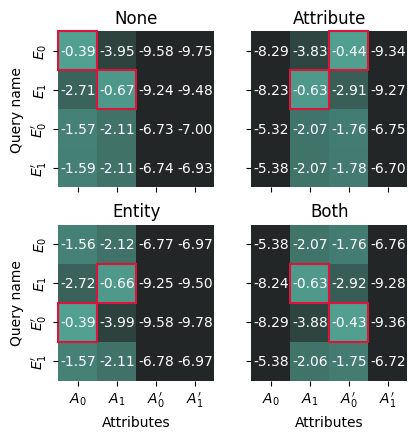

In [6]:
vocab_tag = 'CAPITALS'
country_width=1
entity_width=2
num_entities=2
factorization_results = data_cache(f'factorizability_{vocab_tag}_side_{0}_{entity_width}_{country_width}', lambda:None)
plot_factorization(factorization_results, highlight=highlighted_squares[0])
plt.savefig('figures/factorization_side0.pdf',bbox_inches='tight')

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/factorizability_capitals_side_1_2_1.pt


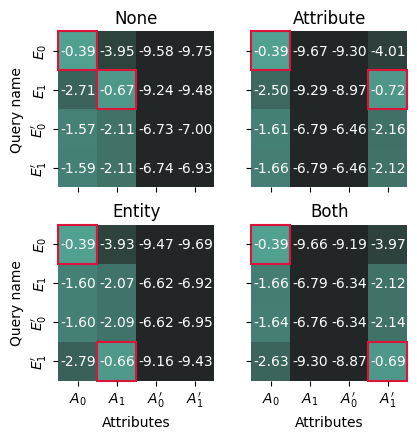

In [7]:
factorization_results = data_cache(f'factorizability_{vocab_tag}_side_{1}_{entity_width}_{country_width}', lambda:None)
fig = plot_factorization(factorization_results, highlight=highlighted_squares[1])
plt.savefig('figures/factorization_side1.pdf',bbox_inches='tight')

## Position independence

In [8]:
vocab_tag='CAPITALS'
num_entities=2

In [9]:
entity_width = 2
country_width = 1
normalize_logits = True

In [10]:

attribute_position_results = data_cache(f'position_{vocab_tag}_countries_{country_width}_normalize_{normalize_logits}', lambda: None)
entity_position_results = data_cache(f'position_{vocab_tag}_entities_{entity_width}_normalize_{normalize_logits}', lambda: None)

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/position_capitals_countries_1_normalize_true.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/position_capitals_entities_2_normalize_true.pt


In [11]:
def plot_1d_logits(
    logits,
    vocab,
    tokens,
    color_labels,
    color_category_label,
    style_labels,
    style_category_label,
    ax=None
):
    '''
    logits: [position, color, style]
    '''
    prompt_position_labels = [
        "<WS>" if tok.isspace() else f"{tok}" for i, tok in enumerate( 
            vocab.tokenizer.batch_decode(tokens))]
    nparr = utils.to_numpy(logits)
    long_data = []
    for (pos, color, style), logit in np.ndenumerate(logits):
        long_data.append({
            color_category_label: color_labels[color],
            style_category_label: style_labels[style],
            'logit': logit,
            'position': pos,
        })
    df = pd.DataFrame(long_data)
    if ax is None:
        fig = plt.figure(figsize=(10, 3))
        ax = fig.add_subplot()
    sns.lineplot(ax=ax, data=df, x='position', y='logit', hue=color_category_label, style=style_category_label)
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Mean Log Prob')
    ax.set_xticks(range(len(prompt_position_labels)), prompt_position_labels, rotation=32, rotation_mode='anchor',ha='right')
    ax.axvline(10, color='grey')
    ax.axvline(len(prompt_position_labels)-10, color='green')
    return ax

In [12]:
import coref.representations as rep
import coref.data_collection as dc
def plot_position_results(results, category, ax=None):
    vocab = load_vocab(vocab_tag, model_tag)
    tokens, _, _, _ = rep.build_example_refactored(
        batch_size=1, 
        vocab=vocab,
        context=vocab.default_context(2),
        num_entities=2,
        fixed_query_name=0,
        prompt_id_start=0,
    )
    selector = dc.build_selector_refactored(dc.default_binding_selector_extractor, vocab, num_entities=2, additional_template_context={})
    start_index = selector[category][0][0]-10
    end_index = results.shape[0] + start_index
    print(start_index, end_index)
    return plot_1d_logits(
        logits=reduce_logit_mean(results),
        tokens=tokens[0, start_index:end_index],
        vocab=vocab,
        color_category_label='Query Name',
        color_labels=['$E_0$', '$E_1$'],
        style_category_label='Attribute',
        style_labels=['$A_0$', '$A_1$'],
        ax=ax
    )

tensor(9) tensor(38)
tensor(16) tensor(45)


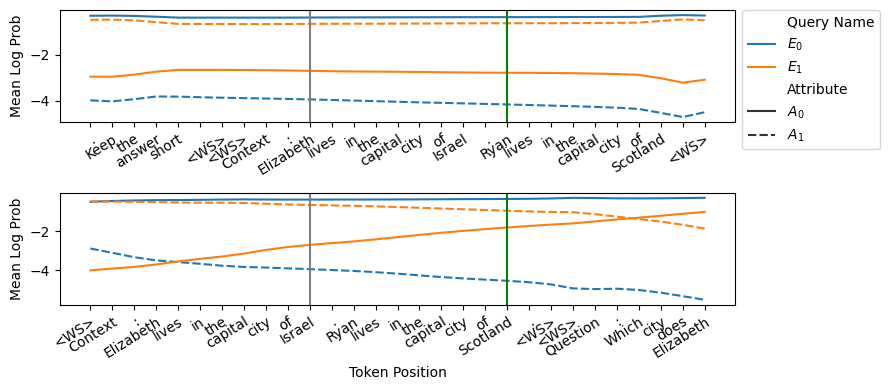

In [13]:

fig, axs = plt.subplots(2, 1, figsize=(9, 4))
plot_position_results(entity_position_results, 'names', ax=axs[0])
axs[0].set(xlabel=None)
axs[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plot_position_results(attribute_position_results, 'countries', ax=axs[1])
axs[1].get_legend().remove()
fig.tight_layout()
plt.savefig('figures/combined_position.pdf', bbox_inches="tight")

## Mean interventions

In [14]:
grid_mean_results = data_cache(f'mean_interventions_{vocab_tag}_{entity_width}_{country_width}', lambda: None)

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_interventions_capitals_2_1.pt


In [15]:
distractor_calibrated_accuracy = reduce_distractor_acc(grid_mean_results, intended_answers=range(num_entities))

In [16]:
print('\n'.join([
    ' & '.join([ f'{distractor_calibrated_accuracy[switch_entities, switch_countries, query_name]:.2f}'
        for switch_entities, switch_countries in [(0, 0), (0, 1), (1, 0), (1, 1)]
    ])
    for query_name in range(2)
]))

0.99 & 0.00 & 0.00 & 0.97
1.00 & 0.03 & 0.01 & 0.99


## Random mean interventions

In [17]:
vocab_tag = 'CAPITALS'
entity_width = 2
country_width = 1
num_entities = 2

In [18]:
grid_mean_results = data_cache(f'mean_interventions_{vocab_tag}_{entity_width}_{country_width}_baseline', lambda: None)

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_interventions_capitals_2_1_baseline.pt


In [19]:
distractor_calibrated_accuracy = reduce_distractor_acc(grid_mean_results, intended_answers=range(num_entities))

In [20]:
print('\n'.join([
    ' & '.join([ f'{distractor_calibrated_accuracy[switch_entities, switch_countries, query_name]:.2f}'
        for switch_entities, switch_countries in [(0, 0), (0, 1), (1, 0), (1, 1)]
    ])
    for query_name in range(2)
]))

0.99 & 0.97 & 0.98 & 0.97
1.00 & 1.00 & 1.00 & 1.00


## All tasks

In [21]:
vocab_list = ['CAPITALS', 'PARALLEL', 'SHAPES', 'FRUITS', 'BIOSBIAS']

is_cyclic = True

entity_width = 2
country_width =1 

In [22]:
def build_intended_answers(num_entities, is_entity=None):
    if is_cyclic:
        assert is_entity is not None
        if is_entity:
            return rep.get_cyclic_perm(num_entities)
        else:
            return rep.get_cyclic_perm(num_entities)[::-1]
    else:
        ret = []
        for swap in rep.get_pairwise_switches(num_entities):
            t = list(range(num_entities))
            t[swap[0]], t[swap[1]] = t[swap[1]], t[swap[0]]
            ret.append(t)
        return ret

def print_table(table):
    return "\n".join(" & ".join(f'{v:.2f}'if type(v) not in [str, np.str_] else v for v in row ) for row in table)

In [23]:
import coref.representations as rep

In [24]:
all_data = []
df = []
for vocab_tag in vocab_list:
    country_data = data_cache(f'mean_countries_interventions' + ('_cyclic' if is_cyclic else '') + f'_{vocab_tag}_{entity_width}_{country_width}', lambda: None)
    entity_data = data_cache(f'mean_entities_interventions' + ('_cyclic' if is_cyclic else '') + f'_{vocab_tag}_{entity_width}_{country_width}', lambda: None)
    baseline_data = data_cache(f'baseline_{vocab_tag}', lambda: None)
    def format_cell(t):
        return t.mean().item()
        return f'{t.min().item():.2f} ({t.mean().item():.2f})'
    all_data.append([
        format_cell(reduce_balanced_acc(baseline_data, [0, 1, 2], ignore_null=True)),
        format_cell(reduce_balanced_acc(entity_data, build_intended_answers(3, is_entity=True), ignore_null=True)),
        format_cell(reduce_balanced_acc(country_data, build_intended_answers(3, is_entity=False), ignore_null=True)),
    ])
    df.append({
        'Task': vocab_tag,
        'Accuracy': reduce_balanced_acc(baseline_data, [0, 1, 2], ignore_null=True).mean().item(),
        'Intervention': 'control'
    })
    df.append({
        'Task': vocab_tag,
        'Accuracy': reduce_balanced_acc(entity_data, build_intended_answers(3, is_entity=True), ignore_null=True).mean().item(),
        'Intervention': 'entity'
    })
    df.append({
        'Task': vocab_tag,
        'Accuracy': reduce_balanced_acc(country_data, build_intended_answers(3, is_entity=False), ignore_null=True).mean().item(),
        'Intervention': 'attribute'
    })

table = np.array(all_data).T
all_task_df = pd.DataFrame(df)
print(print_table(table))

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_countries_interventions_cyclic_capitals_2_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_entities_interventions_cyclic_capitals_2_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/baseline_capitals.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_countries_interventions_cyclic_parallel_2_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_entities_interventions_cyclic_parallel_2_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/baseline_parallel.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_countries_interventions_cy

## across models

In [25]:
from coref.models import PYTHIA_MODELS, LLAMA_MODELS
all_models = {
    'pythia': PYTHIA_MODELS,
    'llama': LLAMA_MODELS[:-1] # remove llama-65
}
model_sizes = {
    'pythia': [.07, .16,.41, 1., 1.4, 2.8, 6.9, 12],
    'llama': [7, 13, 30, 65][:-1] # remove llama-65
}
vocab_tag = 'CAPITALS'
all_results = []
for model_family_name, model_family in all_models.items():
    for other_model_tag, other_model_size in zip(model_family, model_sizes[model_family_name]):
        other_cache = partial(cache, prefixes=[os.path.join(COREF_ROOT, 'cache'), 'paper_data', other_model_tag, time_tag], force_compute=False)
        country_data = other_cache(f'mean_countries_interventions' + ('_cyclic' if is_cyclic else '') + f'_{vocab_tag}_{entity_width}_{country_width}', lambda: None)
        entity_data = other_cache(f'mean_entities_interventions' + ('_cyclic' if is_cyclic else '') + f'_{vocab_tag}_{entity_width}_{country_width}', lambda: None)
        baseline_data = other_cache(f'baseline_{vocab_tag}', lambda: None)
        def format_cell(t):
            return t.mean().item()
            return f'{t.min().item():.2f} ({t.mean().item():.2f})'
        all_results.append({
            'Family': model_family_name,
            'size': other_model_size,
            'Accuracy': format_cell(reduce_balanced_acc(baseline_data, [0, 1, 2], ignore_null=True)),
            'Intervention': 'control'
        })
        all_results.append({
            'Family': model_family_name,
            'size': other_model_size,
            'Accuracy': format_cell(reduce_balanced_acc(country_data, build_intended_answers(3, is_entity=False), ignore_null=True)),
            'Intervention': 'attribute'
        })
    
        all_results.append({
            'Family': model_family_name,
            'size': other_model_size,
            'Accuracy': format_cell(reduce_balanced_acc(entity_data, build_intended_answers(3, is_entity=True), ignore_null=True)),
            'Intervention': 'entity'
        })
all_model_df = pd.DataFrame(all_results)

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/eleutheraipythia-70m/results/mean_countries_interventions_cyclic_capitals_2_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/eleutheraipythia-70m/results/mean_entities_interventions_cyclic_capitals_2_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/eleutheraipythia-70m/results/baseline_capitals.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/eleutheraipythia-160m/results/mean_countries_interventions_cyclic_capitals_2_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/eleutheraipythia-160m/results/mean_entities_interventions_cyclic_capitals_2_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/eleutheraipythia-160m/results/baseline_capitals.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/e

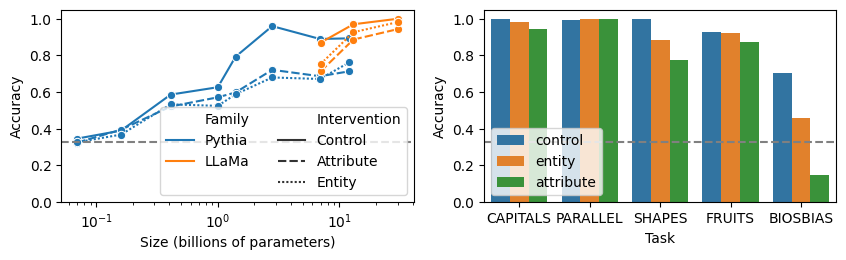

In [26]:
import matplotlib.patches as mpatches
fig, axs = plt.subplots(1,2, figsize=(10, 2.5))

def plot_all_models(df, ax):
    sns.lineplot(df, x='size', y='Accuracy', hue='Family', style='Intervention', marker='o', ax=ax)
    ax.semilogx()
    ax.set_xlabel('Size (billions of parameters)')
    ax.axhline(0.33, linestyle='--', color='grey')
    ax.set_ylim([0, 1.05])
    handles = ax.legend().legend_handles
    handles = handles[:3] + [ mpatches.Patch(color='white') ] + handles[3:]
    labels = ['Family', 'Pythia', 'LLaMa', ' ', 'Intervention', 'Control', 'Attribute', 'Entity']
    
    ax.legend(handles, labels, loc='lower right', ncols=2)
def plot_all_task(df, ax):
    sns.barplot(df, x='Task', y='Accuracy', hue='Intervention', ax = ax)
    ax.axhline(0.33, linestyle='--', color='grey')
    ax.set_ylim([0, 1.05])
    ax.legend(loc='lower left')

plot_all_models(all_model_df, axs[0])
plot_all_task(all_task_df, axs[1])


plt.savefig('figures/combined_model_task.pdf', bbox_inches="tight")



## Cross tasks Subspace

In [27]:
build_intended_answers(3, is_entity=False)

[[2, 0, 1], [1, 2, 0]]

In [28]:
source_vocab_list = vocab_list + ['ZEROS', 'RANDOM']

In [29]:
target_vocab_tag = 'CAPITALS'
all_data = []
spread = False
for source_vocab_tag in source_vocab_list:
    data = data_cache(f'mean_cross_cyclic_subspace' + f'_{source_vocab_tag}_{target_vocab_tag}_{entity_width}_{country_width}_{spread}', lambda: None)
    def format_cell(t):
        return t.mean().item()
        return f'{t.min().item():.2f} ({t.mean().item():.2f})'
    all_data.append([
        format_cell(reduce_balanced_acc(data, build_intended_answers(3, is_entity=False), ignore_null=True)),
        reduce_mean_correct_logit(data, build_intended_answers(3, is_entity=False), ignore_null=True).mean().item()
    ])
table = np.array(all_data).T
print(print_table(table))

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_cross_cyclic_subspace_capitals_capitals_2_1_false.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_cross_cyclic_subspace_parallel_capitals_2_1_false.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_cross_cyclic_subspace_shapes_capitals_2_1_false.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_cross_cyclic_subspace_fruits_capitals_2_1_false.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_cross_cyclic_subspace_biosbias_capitals_2_1_false.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_cross_cyclic_subspace_zeros_capitals_2_1_false.pt
using cached /accounts/projects/jsteinhar

In [30]:
data = data_cache(f'mean_cross_cyclic_subspace' + f'_{"RANDOM"}_{target_vocab_tag}_{entity_width}_{country_width}_{spread}', lambda: None)

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-30b-hf/results/mean_cross_cyclic_subspace_random_capitals_2_1_false.pt


## mcq plots

In [31]:
model_tag="tulu-13b"
data_cache = partial(cache, prefixes=[os.path.join(COREF_ROOT, 'cache'), 'paper_data', model_tag, time_tag], force_compute=False) # uncrossed

In [32]:
vocab_tag = 'MCQ_SST'
max_width=5

In [33]:
mcq_data = data_cache(f'mcq_{vocab_tag}_width_{max_width}', None)

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/tulu-13b/results/mcq_mcq_sst_width_5.pt


In [34]:

def plot_mcq_results(mcq_data):
    res = []
    for t in mcq_data:
        res.append(reduce_balanced_acc(t, [1, 0], ignore_null=False).mean().item())
        # res.append(reduce_mean_logit(t, [1, 0], ignore_null=False).mean().item())
    res = torch.tensor(res[::-1])
    

    vocab = load_vocab(vocab_tag, model_tag)
    tokens, _, _, _ = rep.build_example_refactored(
        batch_size=1, 
        vocab=vocab,
        context=vocab.default_context(2),
        num_entities=2,
        fixed_query_name=0,
        prompt_id_start=0,
    )
    selector = dc.build_selector_refactored(dc.statements_mcq_selector_extractor, vocab, num_entities=2, additional_template_context={})
    
    end_index = selector['sentence_ends'][0][0] + 1 
    start_index = end_index - mcq_data.shape[0] + 1
    
    # plotting
    
    prompt_position_labels = [
        "<WS>" if tok.isspace() else f"{tok}" for i, tok in enumerate( 
            vocab.tokenizer.batch_decode(tokens[0, start_index:end_index]))] + ["[Control]"]
    nparr = utils.to_numpy(res)
    long_data = []
    for (pos,), logit in np.ndenumerate(res):
        long_data.append({
            'accuracy': logit,
            'position': pos,
        })
    df = pd.DataFrame(long_data)
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot()
    sns.lineplot(ax=ax, data=df, x='position', y='accuracy')
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Mean Accuracy')
    ax.set_xticks(range(len(prompt_position_labels)), prompt_position_labels, rotation=45, rotation_mode='anchor',ha='right')
    fig.tight_layout()
    return ax

Found cached dataset parquet (/scratch/users/fjiahai/huggingface-cache/parquet/sst2-1151590ea3b3f98b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

<Axes: xlabel='Token Position', ylabel='Mean Accuracy'>

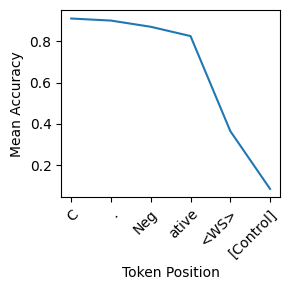

In [35]:
plot_mcq_results(mcq_data)

## subspace plots

Plan:
- get mean estimates for 3 estimates
- orthogonalize the second guy to get another set of basis vectors
    - we want to project guy two onto orthogonal plane to guy one
- compute second guy's coordinates in terms of the first one
    - should obtain the standard thing
- compute plots?
    -  lets say we have 12 x 12 grid. with 50 samples


In [36]:
model_tag="llama-13b-hf"
data_cache = partial(cache, prefixes=[os.path.join(COREF_ROOT, 'cache'), 'paper_data', model_tag, time_tag], force_compute=False) # uncrossed
cross_countries = False

In [37]:
vocab_tag='CAPITALS'

In [38]:
entity_width = 2
country_width = 1

In [39]:
grid_0_0 = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_0_0', lambda: None)
grid_1_0 = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_1_0', lambda: None)
grid_0_1 = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_0_1', lambda: None)
grid_1_1 = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_1_1', lambda: None)
grid_5_5 = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_0.5_0.5', lambda: None)
grid_2_1 = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_0.2_0.1', lambda: None)
grid_5_7 = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_0.5_0.7', lambda: None)
grid_7_1 = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_0.7_0.1', lambda: None)
grid_0_5 = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_0_0.5', lambda: None)

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-13b-hf/results/subspace_capitals_false_2_1_0_0.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-13b-hf/results/subspace_capitals_false_2_1_1_0.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-13b-hf/results/subspace_capitals_false_2_1_0_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-13b-hf/results/subspace_capitals_false_2_1_1_1.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-13b-hf/results/subspace_capitals_false_2_1_05_05.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-13b-hf/results/subspace_capitals_false_2_1_02_01.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-13b-hf/results/subspace_capitals_false_2_1_05_07.pt
using cached /accounts/proje

In [40]:
coeffs = data_cache(f'subspace_{vocab_tag}_{cross_countries}_{entity_width}_{country_width}_coeff', lambda: None)

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-13b-hf/results/subspace_capitals_false_2_1_coeff.pt


In [41]:
res = grid_0_5.shape[0]

In [42]:
range0=[-0.5, 1.5]
range1=[-0.5, 1.5]
res0=res
res1=res

In [43]:
coeffs

[tensor(0.9430), tensor(0.9999)]

In [44]:
def plot_grid_logits(data, coeffs, root):
    logit_means = reduce_logit_mean(data)
    estimates = logit_means[..., 0, 0] + logit_means[..., 1,1] - logit_means[..., 0,1] - logit_means[..., 1, 0]
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot()

    height_0 = (range0[1] - range0[0])/(res - 1)
    height_1 = (range1[1] - range1[0])/(res - 1)

    im = ax.imshow(
        estimates.T.flip(dims=[0]), 
        extent=(range0[0]-height_0/2, range0[1]+height_0/2, range1[0]-height_1/2, range1[1]+height_1/2, ), 
        cmap='Reds',
        # vmin=0, 
        # vmax=8
    )

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Logit Difference', rotation=-90, va="bottom")
    ax.plot(*root, marker='o', color="blue")
    ax.arrow(0, 0, 1, 0, width=0.005, head_width=0.06, color='black', length_includes_head=True)
    ax.arrow(0, 0, coeffs[0], coeffs[1], width=0.005, head_width=0.06, color='black', length_includes_head=True)

In [45]:
def plot_grid_acc(data, coeffs, root, ax=None, plot_cbar=True):
    # estimates = reduce_distractor_acc(data, [0, 1]).min(dim=-1).values
    estimates = reduce_distractor_acc(data, [0, 1]).mean(dim=-1)
    if ax is None:
        fig = plt.figure(figsize=(3, 3))
        ax = fig.add_subplot()

    height_0 = (range0[1] - range0[0])/(res - 1)
    height_1 = (range1[1] - range1[0])/(res - 1)

    im = ax.imshow(estimates.T.flip(dims=[0]), extent=(range0[0]-height_0/2, range0[1]+height_0/2, range1[0]-height_1/2, range1[1]+height_1/2, ), cmap='bwr', vmin=0, vmax=1)

    # cbar = ax.figure.colorbar(im, ax=ax)
    # cbar.ax.set_ylabel('acc', rotation=-90, va="bottom")
    ax.plot(*root, marker='o', color="#2df781")
    ax.arrow(0, 0, 1, 0, width=0.005, head_width=0.06, color='black', length_includes_head=True)
    ax.arrow(0, 0, coeffs[0], coeffs[1], width=0.005, head_width=0.06, color='black', length_includes_head=True)
    return im

In [46]:
def plot_grid(data, coeffs, root, ax=None, plot_cbar=True):
    statistic = 'acc'
    if statistic == 'acc':
        return plot_grid_acc(data, coeffs, root, ax, plot_cbar=plot_cbar)
    else:
        return plot_grid_logits(data, coeffs, root)

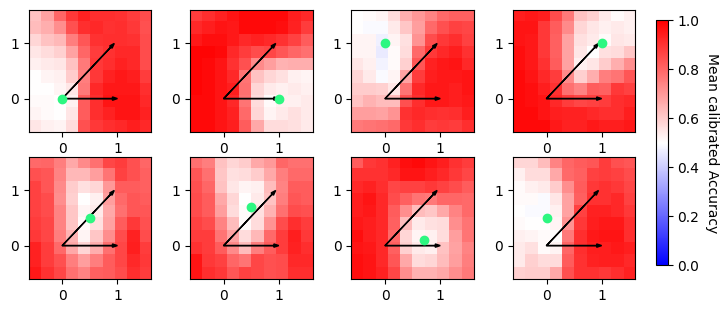

In [47]:
grids = [
    (grid_0_0, [0, 0]),
    (grid_1_0, [1, 0]),
    (grid_0_1, [0, 1]),
    (grid_1_1, [1, 1]),
    (grid_5_5, [.5, .5]),
    # (grid_2_1, [.2, .1]),
    (grid_5_7, [.5, .7]),
    (grid_7_1, [.7, .1]),
    (grid_0_5, [0., .5]),
]
fig, axs = plt.subplots(2, 4, figsize=(7.5, 3.5))
ims = []
for (grid, root), ax in zip(grids, axs.flatten()):
    ims.append(
        plot_grid(grid, coeffs, root, ax, False)
    )

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.015, 0.7])
cbar = fig.colorbar(ims[-2], cax=cbar_ax)
cbar_ax.set_ylabel('Mean calibrated Accuracy', rotation=-90, va="bottom")
# fig.tight_layout()
plt.savefig('figures/subspace_uncrossed.pdf', bbox_inches="tight")


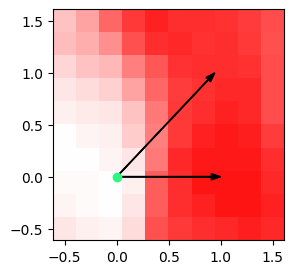

In [48]:
plot_grid(grid_0_0, coeffs, [0, 0])

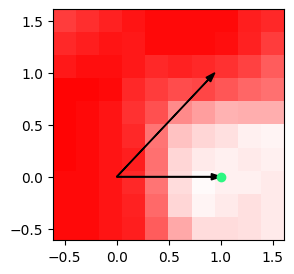

In [49]:
plot_grid(grid_1_0, coeffs, [1, 0])

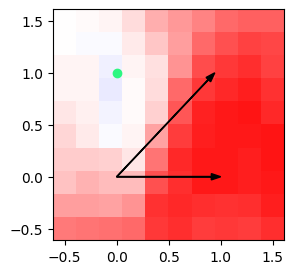

In [50]:
plot_grid(grid_0_1, coeffs, [0, 1])

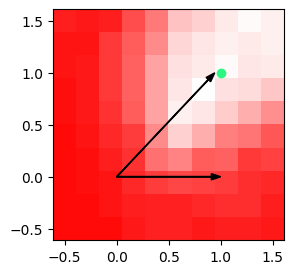

In [51]:
plot_grid(grid_1_1, coeffs, [1, 1])

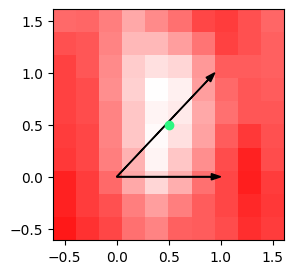

In [52]:
plot_grid(grid_5_5, coeffs, [.5, .5])

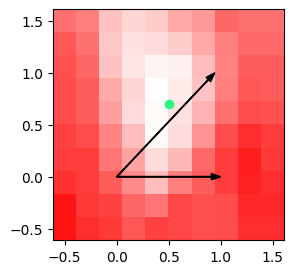

In [53]:
plot_grid(grid_5_7, coeffs, [.5, .7])

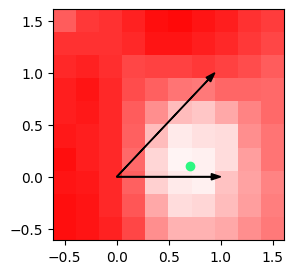

In [54]:
plot_grid(grid_7_1, coeffs, [.7, .1])

# Rebuttal plots

## One hop plots

In [55]:
time_tag = 'results'
model_tag="llama-65b-hf"
data_cache = partial(cache, prefixes=[os.path.join(COREF_ROOT, 'cache'), 'paper_data', model_tag, time_tag], force_compute=False)

In [56]:
highlighted_squares = [
    [
        [(0, 0), (1, 1)],
        [(0, 2), (1, 1)],
        [(2, 0), (1, 1)],
        [(2, 2), (1, 1)]
    ],
    [
        [(0, 0), (1, 1)],
        [(0, 0), (1, 3)],
        [(0, 0), (3, 1)],
        [(0, 0), (3, 3)]
    ]
]

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-65b-hf/results/factorizability_onehop_side_0_2_2.pt


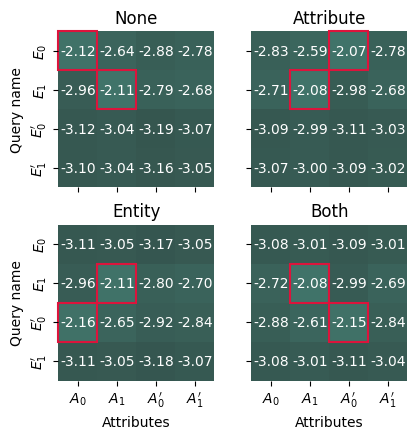

In [57]:
vocab_tag = 'ONEHOP'
country_width=2 
entity_width=2
num_entities=2
factorization_results = data_cache(f'factorizability_{vocab_tag}_side_{0}_{entity_width}_{country_width}', lambda:None)
plot_factorization(factorization_results, highlight=highlighted_squares[0])
plt.savefig(f'figures/factorization_{vocab_tag}_side0.pdf',bbox_inches='tight')

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-65b-hf/results/factorizability_onehop_side_1_2_2.pt


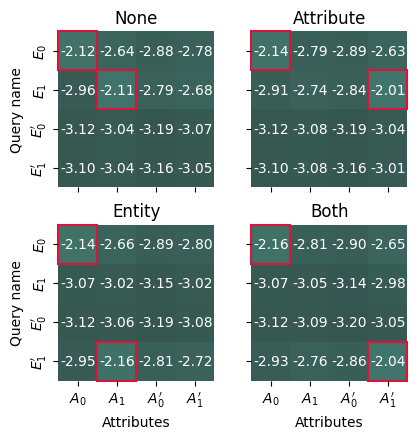

In [58]:
factorization_results = data_cache(f'factorizability_{vocab_tag}_side_{1}_{entity_width}_{country_width}', lambda:None)
fig = plot_factorization(factorization_results, highlight=highlighted_squares[1])
plt.savefig(f'figures/factorization_{vocab_tag}_side1.pdf',bbox_inches='tight')

In [59]:
vocab_tag='ONEHOP'
num_entities=2

In [60]:
entity_width = 2
country_width = 2 # 2 in new run, 1 in old run
normalize_logits = True

In [61]:

attribute_position_results =[
    data_cache(f'local_position_tail_{is_tail}_{vocab_tag}_countries_{country_width}_normalize_{normalize_logits}', lambda: None).float()
    for is_tail in [False, True]
]
entity_position_results = [
    data_cache(f'local_position_tail_{is_tail}_{vocab_tag}_entities_{entity_width}_normalize_{normalize_logits}', lambda: None).float()
    for is_tail in [False, True]
]

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-65b-hf/results/local_position_tail_false_onehop_countries_2_normalize_true.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-65b-hf/results/local_position_tail_true_onehop_countries_2_normalize_true.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-65b-hf/results/local_position_tail_false_onehop_entities_2_normalize_true.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-65b-hf/results/local_position_tail_true_onehop_entities_2_normalize_true.pt


In [62]:
def plot_split_1d_logits(
    logits,
    vocab,
    tokens,
    color_labels,
    color_category_label,
    style_labels,
    style_category_label,
    ax,
    is_tail=False,
    raw_labels=False
):
    '''
    logits: [position, color, style]
    '''
    if raw_labels:
        prompt_position_labels = tokens
    else:
        prompt_position_labels = [
            "<WS>" if tok.isspace() else f"{tok}" for i, tok in enumerate( 
                vocab.tokenizer.batch_decode(tokens))]
    nparr = utils.to_numpy(logits)
    long_data = []
    for (pos, color, style), logit in np.ndenumerate(logits):
        long_data.append({
            color_category_label: color_labels[color],
            style_category_label: style_labels[style],
            'logit': logit,
            'position': pos,
        })
    df = pd.DataFrame(long_data)
    sns.lineplot(ax=ax, data=df, x='position', y='logit', hue=color_category_label, style=style_category_label)
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Mean Log Prob')
    ax.set_xticks(range(len(prompt_position_labels)), prompt_position_labels, rotation=32, rotation_mode='anchor',ha='right')
    if is_tail:
        ax.axvline(2, color='green')
        ax.spines['left'].set_visible(False)
        d = .015 # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        ax.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
        ax.yaxis.tick_right()

    else:
        ax.spines['right'].set_visible(False)
        ax.axvline(2, color='grey')
        d = .015 # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    ax.set_xlim(-1, 5)
    
    return ax

In [63]:
import coref.representations as rep
import coref.data_collection as dc
def plot_local_position_results(results, category, is_tail, ax):
    vocab = load_vocab(vocab_tag, model_tag)
    tag = '[SWAP]' if is_tail else '[CTRL]' 
    tokens = [tag + f'{i:+}' for i in range(-2, 3)]
    return plot_split_1d_logits(
        logits=reduce_logit_mean(results),
        tokens=tokens,
        vocab=vocab,
        color_category_label='Query Name',
        color_labels=['$E_0$', '$E_1$'],
        style_category_label='Attribute',
        style_labels=['$A_0$', '$A_1$'],
        ax=ax,
        is_tail=is_tail,
        raw_labels=True
    )

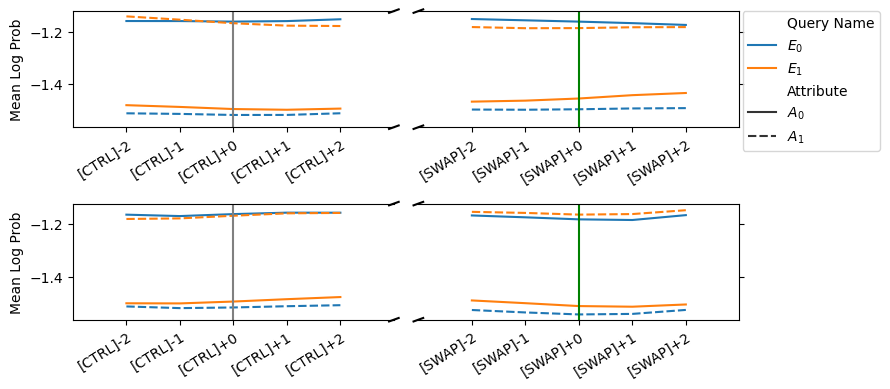

In [64]:

fig, axs = plt.subplots(2, 2, figsize=(9, 4), sharey=True)
plot_local_position_results(entity_position_results[0], 'names', False, ax=axs[0,0])
plot_local_position_results(entity_position_results[1], 'names', True, ax=axs[0,1])
axs[0,0].set(xlabel=None)
axs[0,1].set(xlabel=None)
axs[0,1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
axs[0,0].get_legend().remove()

plot_local_position_results(attribute_position_results[0], 'countries', False, ax=axs[1,0])
plot_local_position_results(attribute_position_results[1], 'countries', True, ax=axs[1,1])
axs[1,0].set(xlabel=None)
axs[1,1].set(xlabel=None)
axs[1,0].get_legend().remove()
axs[1,1].get_legend().remove()
fig.tight_layout()
plt.savefig(f'figures/local_position_{vocab_tag}.pdf', bbox_inches="tight")

In [65]:
grid_mean_results = data_cache(f'mean_interventions_{vocab_tag}_{entity_width}_{country_width}', lambda: None).float()

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-65b-hf/results/mean_interventions_onehop_2_2.pt


In [66]:
distractor_calibrated_accuracy = reduce_distractor_acc(grid_mean_results, intended_answers=range(num_entities))

In [67]:
print('\n'.join([
    ' & '.join([ f'{distractor_calibrated_accuracy[switch_entities, switch_countries, query_name]:.2f}'
        for switch_entities, switch_countries in [(0, 0), (0, 1), (1, 0), (1, 1)]
    ])
    for query_name in range(2)
]))

0.73 & 0.25 & 0.24 & 0.71
0.79 & 0.28 & 0.26 & 0.77


In [68]:
is_cyclic = True

country_data = data_cache(f'mean_countries_interventions' + ('_cyclic' if is_cyclic else '') + f'_{vocab_tag}_{entity_width}_{country_width}', lambda: None).float()
entity_data = data_cache(f'mean_entities_interventions' + ('_cyclic' if is_cyclic else '') + f'_{vocab_tag}_{entity_width}_{country_width}', lambda: None).float()
# baseline_data = data_cache(f'baseline_{vocab_tag}', lambda: None)
def format_cell(t):
    return t.mean().item()
    return f'{t.min().item():.2f} ({t.mean().item():.2f})'
# print(reduce_balanced_acc(baseline_data, [0, 1, 2], ignore_null=True).mean().item())
print(reduce_balanced_acc(entity_data, build_intended_answers(3, is_entity=True), ignore_null=True).mean().item())
print(reduce_balanced_acc(country_data, build_intended_answers(3, is_entity=False), ignore_null=True).mean().item())

using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-65b-hf/results/mean_countries_interventions_cyclic_onehop_2_2.pt
using cached /accounts/projects/jsteinhardt/fjiahai/binding-iclr/cache/paper_data/llama-65b-hf/results/mean_entities_interventions_cyclic_onehop_2_2.pt
0.59333336353302
0.6066666841506958


## Factorizability and Position for everything

In [ ]:
time_tag = 'results'
model_tag="llama-30b-hf"
data_cache = partial(cache, prefixes=[os.path.join(COREF_ROOT, 'cache'), 'paper_data', model_tag, time_tag], force_compute=False)

In [ ]:
highlighted_squares = [
    [
        [(0, 0), (1, 1)],
        [(0, 2), (1, 1)],
        [(2, 0), (1, 1)],
        [(2, 2), (1, 1)]
    ],
    [
        [(0, 0), (1, 1)],
        [(0, 0), (1, 3)],
        [(0, 0), (3, 1)],
        [(0, 0), (3, 3)]
    ]
]

In [ ]:
vocab_tag = 'PARALLEL'
country_width=1
entity_width=2
num_entities=2
for vocab_tag in ["CAPITALS", "PARALLEL", "SHAPES", "FRUITS", "BIOSBIAS"]:
    factorization_results = data_cache(f'factorizability_{vocab_tag}_side_{0}_{entity_width}_{country_width}', lambda:None)
    plot_factorization(factorization_results, highlight=highlighted_squares[0])
    plt.savefig(f'figures/factorization_{vocab_tag}_side0.pdf',bbox_inches='tight')

In [ ]:

for vocab_tag in ["CAPITALS", "PARALLEL", "SHAPES", "FRUITS", "BIOSBIAS"]:
    factorization_results = data_cache(f'factorizability_{vocab_tag}_side_{1}_{entity_width}_{country_width}', lambda:None)
    fig = plot_factorization(factorization_results, highlight=highlighted_squares[1])
    plt.savefig(f'figures/factorization_{vocab_tag}_side1.pdf',bbox_inches='tight')

In [ ]:
def plot_split_1d_logits(
    logits,
    vocab,
    tokens,
    color_labels,
    color_category_label,
    style_labels,
    style_category_label,
    ax,
    is_tail=False,
    raw_labels=False
):
    '''
    logits: [position, color, style]
    '''
    if raw_labels:
        prompt_position_labels = tokens
    else:
        prompt_position_labels = [
            "<WS>" if tok.isspace() else f"{tok}" for i, tok in enumerate( 
                vocab.tokenizer.batch_decode(tokens))]
    nparr = utils.to_numpy(logits)
    long_data = []
    for (pos, color, style), logit in np.ndenumerate(logits):
        long_data.append({
            color_category_label: color_labels[color],
            style_category_label: style_labels[style],
            'logit': logit,
            'position': pos,
        })
    df = pd.DataFrame(long_data)
    sns.lineplot(ax=ax, data=df, x='position', y='logit', hue=color_category_label, style=style_category_label)
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Mean Log Prob')
    ax.set_xticks(range(len(prompt_position_labels)), prompt_position_labels, rotation=32, rotation_mode='anchor',ha='right')
    if is_tail:
        ax.axvline(2, color='green')
        ax.spines['left'].set_visible(False)
        d = .015 # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        ax.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
        ax.yaxis.tick_right()

    else:
        ax.spines['right'].set_visible(False)
        ax.axvline(2, color='grey')
        d = .015 # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    ax.set_xlim(-1, 5)
    
    return ax

In [ ]:
import coref.representations as rep
import coref.data_collection as dc
def plot_local_position_results(results, category, is_tail, ax):
    vocab = load_vocab(vocab_tag, model_tag)
    selector = dc.build_selector_refactored(dc.default_binding_selector_extractor, vocab, num_entities=2)
    start_index = selector[category][0][0]-2
    end_index = results.shape[0] + start_index
    print(start_index, end_index)
    tag = '[SWAP]' if is_tail else '[CTRL]' 
    tokens = [tag + f'{i:+}' for i in range(-2, 3)]
    return plot_split_1d_logits(
        logits=reduce_logit_mean(results),
        tokens=tokens,
        vocab=vocab,
        color_category_label='Query Name',
        color_labels=['$E_0$', '$E_1$'],
        style_category_label='Attribute',
        style_labels=['$A_0$', '$A_1$'],
        ax=ax,
        is_tail=is_tail,
        raw_labels=True
    )

In [ ]:
vocab_tag='SHAPES'
num_entities=2

In [ ]:
entity_width = 2
country_width = 1
normalize_logits = True

In [ ]:

for vocab_tag in ["CAPITALS", "PARALLEL", "SHAPES", "FRUITS", "BIOSBIAS"]:
    attribute_position_results =[
        data_cache(f'local_position_tail_{is_tail}_{vocab_tag}_countries_{country_width}_normalize_{normalize_logits}', lambda: None)
        for is_tail in [False, True]
    ]
    entity_position_results = [
        data_cache(f'local_position_tail_{is_tail}_{vocab_tag}_entities_{entity_width}_normalize_{normalize_logits}', lambda: None)
        for is_tail in [False, True]
    ]


    fig, axs = plt.subplots(2, 2, figsize=(9, 4), sharey=True)
    plot_local_position_results(entity_position_results[0], 'names', False, ax=axs[0,0])
    plot_local_position_results(entity_position_results[1], 'names', True, ax=axs[0,1])
    axs[0,0].set(xlabel=None)
    axs[0,1].set(xlabel=None)
    axs[0,1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    axs[0,0].get_legend().remove()

    plot_local_position_results(attribute_position_results[0], 'countries', False, ax=axs[1,0])
    plot_local_position_results(attribute_position_results[1], 'countries', True, ax=axs[1,1])
    axs[1,0].set(xlabel=None)
    axs[1,1].set(xlabel=None)
    axs[1,0].get_legend().remove()
    axs[1,1].get_legend().remove()
    fig.tight_layout()
    plt.savefig(f'figures/local_position_{vocab_tag}.pdf', bbox_inches="tight")

In [ ]:
grid_mean_results = data_cache(f'mean_interventions_{vocab_tag}_{entity_width}_{country_width}', lambda: None)

In [ ]:
distractor_calibrated_accuracy = reduce_distractor_acc(grid_mean_results, intended_answers=range(num_entities))

In [ ]:
print('\n'.join([
    ' & '.join([ f'{distractor_calibrated_accuracy[switch_entities, switch_countries, query_name]:.2f}'
        for switch_entities, switch_countries in [(0, 0), (0, 1), (1, 0), (1, 1)]
    ])
    for query_name in range(2)
]))